In [968]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from datetime import date
from sklearn.model_selection import train_test_split

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Read raw data - from local file if available, else from internet and write to local file
if os.path.exists('data/data.csv.gz'):
    dfFull = pd.read_csv('data/data.csv.gz', compression='gzip',index_col=0)
elif os.path.exists('../data/data.csv.gz'):
    dfFull = pd.read_csv('../data/data.csv.gz', compression='gzip',index_col=0)
else:
    YEARS = np.arange(1999,date.today().year)
    dfFull = pd.DataFrame()
    for i in YEARS:
        sys.stdout.write(f'{i} \r'); sys.stdout.flush()
        iData = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                             'play_by_play_' + str(i) + '.csv.gz?raw=True',
                             compression='gzip', low_memory=False)
        dfFull = dfFull.append(iData, sort=True)

    dfFull.reset_index(drop=True, inplace=True)
    dfFull.to_csv('../data/data.csv.gz', compression='gzip')

C:\Users\mrkawa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (11,12,13,14,15,16,23,24,62,63,79,80,81,93,94,95,100,101,102,132,133,134,135,136,137,138,139,144,145,150,157,158,164,165,166,167,184,204,205,206,207,219,249,250,251,255,257,260,261,262,263,306,310) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [646]:
# Lookup table with all features of the raw data
featureInfo = pd.read_csv('features.csv').iloc[:,0:4]
# print(featureInfo[featureInfo.Use==1])

idCols = featureInfo[(featureInfo.Use==1) & (featureInfo.Type == 'ID')].Field.tolist() + ['receiver_player_name']
valCols = featureInfo[(featureInfo.Use==1) & (featureInfo.Type != 'ID')].Field.tolist() + ['season', 'game_id'] 
notUsed = [col for col in d.columns if col not in idCols + valCols]
df = dfFull[['season'] + [x for x in featureInfo[(featureInfo.Use==1)].Field] + ['receiver_player_name','rusher_player_name']]
                                                                                 
def lookup(s):
    return featureInfo[featureInfo.Field.str.contains(s)]

# Flex, Full Season Projections
## All season total stats

In [790]:
# Filter to relevant plays
df = df.dropna(subset=['receiver_player_name','rusher_player_name'], how='all')#[df.season>=2011]

df['player_name'] = df.receiver_player_name.fillna(df.rusher_player_name)
df['rec_yards'] = df.pass_attempt * df.yards_gained
df['rush_yards'] = df.rush_attempt * df.yards_gained

In [812]:
# Sum all metrics per player per season
seasonTotals = df.groupby(['season','player_name']).sum().drop(['play_id','qb_scramble','sack','safety'],axis=1)

seasonTotals.columns
# seasonTotals.describe().transpose()[['min','max','mean','std']] #df info

Index(['complete_pass', 'fumble', 'incomplete_pass', 'interception',
       'no_huddle', 'pass_attempt', 'pass_touchdown', 'qb_dropback', 'qb_hit',
       'rush_attempt', 'rush_touchdown', 'shotgun', 'tackled_for_loss',
       'touchdown', 'air_yards', 'yards_after_catch', 'yards_gained',
       'rec_yards', 'rush_yards'],
      dtype='object')

In [823]:
# Calculate fantasy points
if not 'fanPts' in seasonTotals.columns:
    seasonTotals.insert(0,'fanPts',0)

ppr = 0
seasonTotals.fanPts = seasonTotals.yards_gained/10 + seasonTotals.touchdown*6 - 2*seasonTotals.fumble + seasonTotals.complete_pass*ppr

In [967]:
# Append data from N previous seasons as new columns 
seasonHist = seasonTotals.copy()
currentYear = 2019
lookback = 3
for i in range(1,lookback+1):
    temp = seasonTotals.copy().reset_index()
    temp = temp[temp.season.isin(range(1999,currentYear-i+1))]
    temp['season'] = temp.season+i
    seasonHist = seasonHist.join(temp.set_index(['season','player_name']),how='outer',rsuffix=f'-{i}')

# Remove no longer active players
seasonHist = seasonHist.dropna(subset=['fanPts'])
seasonHist.to_csv('seasonHist.csv')

In [839]:
# Partition training, dev, and test data
X = seasonHist \
    .loc[:,seasonHist.columns.str.contains('-\d+') | seasonHist.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonHist.fanPts

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [949]:
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(X.loc[:,keepCols], y, test_size=0.3, random_state=0)
X_dev_select, X_test_select, y_dev_select, y_test_select = train_test_split(X_test_select, y_test_select, test_size=0.5, random_state=0)

### Linear Regression

#### Base model

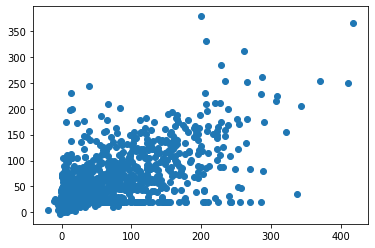

MSE: 2249.5
R^2: 0.45


,touchdown-1,fumble-1,fanPts-1,yards_gained-1,rec_yards-1,rush_yards-1,rush_yards-3,rec_yards-3,yards_gained-3,pass_touchdown-3,yards_gained-2,rush_yards-2,rec_yards-2,rush_touchdown-3,rush_touchdown-2,pass_touchdown-2,interception-2,complete_pass-2,pass_attempt-2,incomplete_pass-2,incomplete_pass-1,fumble-2,complete_pass-1,complete_pass-3,pass_attempt-3,fumble-3,incomplete_pass-3,pass_attempt-1,interception-1,interception-3,rush_touchdown-1,fanPts-3,touchdown-2,pass_touchdown-1,touchdown-3,qb_hit-2,fanPts-2,qb_dropback-1,qb_hit-1,tackled_for_loss-1,rush_attempt-1,qb_hit-3,qb_dropback-3,tackled_for_loss-3,rush_attempt-3,no_huddle-1,qb_dropback-2,shotgun-1,no_huddle-3,shotgun-3,tackled_for_loss-2,no_huddle-2,yards_after_catch-1,rush_attempt-2,shotgun-2,yards_after_catch-2,air_yards-2,yards_after_catch-3,air_yards-3,air_yards-1
1,-65970653541.358,21990217846.045,10995108923.583,-1099510880.313,-11.963,-11.903,9.725,9.705,-9.575,7.765,6.991,-6.919,-6.892,6.533,5.209,4.728,4.477,3.763,-3.742,3.312,2.626,-2.426,2.295,-2.256,2.210,-1.972,-1.968,-1.956,1.775,-1.304,1.136,-1.073,-1.024,1.000,-0.676,-0.611,-0.593,-0.481,-0.474,0.469,-0.322,0.263,-0.256,0.184,-0.153,-0.106,-0.081,0.057,0.057,-0.052,-0.023,-0.018,-0.015,0.014,0.013,0.009,0.008,0.008,-0.007,0.003


In [966]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.show()

print(f'MSE: {mean_squared_error(y_dev, y_pred).round(1)}')
print(f'R^2: {r2_score(y_dev, y_pred).round(2)}')

coefs = pd.DataFrame([X_train.columns,regr.coef_]).transpose()
coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()

### Ridge Regression

#### Base model

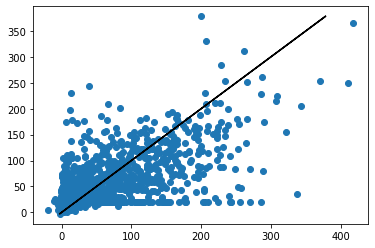

MSE: 2244.2
R^2: 0.45


,rush_yards-3,rec_yards-3,yards_gained-3,pass_touchdown-3,yards_gained-1,rec_yards-1,rush_yards-1,rush_touchdown-3,yards_gained-2,rush_yards-2,rec_yards-2,rush_touchdown-2,pass_touchdown-2,interception-2,complete_pass-2,pass_attempt-2,incomplete_pass-2,incomplete_pass-1,fumble-2,complete_pass-1,complete_pass-3,pass_attempt-3,fumble-3,pass_attempt-1,incomplete_pass-3,interception-1,interception-3,rush_touchdown-1,fanPts-3,touchdown-2,pass_touchdown-1,fumble-1,touchdown-3,qb_hit-2,fanPts-2,qb_dropback-1,qb_hit-1,tackled_for_loss-1,touchdown-1,rush_attempt-1,qb_hit-3,qb_dropback-3,tackled_for_loss-3,rush_attempt-3,no_huddle-1,fanPts-1,qb_dropback-2,shotgun-1,no_huddle-3,shotgun-3,tackled_for_loss-2,no_huddle-2,yards_after_catch-1,rush_attempt-2,shotgun-2,yards_after_catch-2,yards_after_catch-3,air_yards-2,air_yards-3,air_yards-1
1,8.666,8.646,-8.517,7.738,6.903,-6.831,-6.770,6.506,6.330,-6.258,-6.231,5.192,4.712,4.443,3.733,-3.710,3.281,2.613,-2.426,2.282,-2.230,2.183,-1.958,-1.945,-1.941,1.762,-1.280,1.128,-1.067,-1.013,0.991,-0.938,-0.689,-0.611,-0.592,-0.480,-0.472,0.470,-0.412,-0.322,0.263,-0.255,0.184,-0.153,-0.106,0.093,-0.081,0.057,0.057,-0.052,-0.022,-0.018,-0.015,0.014,0.012,0.009,0.008,0.008,-0.007,0.003


In [960]:
clf = linear_model.Ridge()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

print(f'MSE: {mean_squared_error(y_dev, y_pred).round(1)}')
print(f'R^2: {r2_score(y_dev, y_pred).round(2)}')

coefs = pd.DataFrame([X_train.columns,clf.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Best parameters set found on development set:
{'alpha': 100000, 'normalize': False}


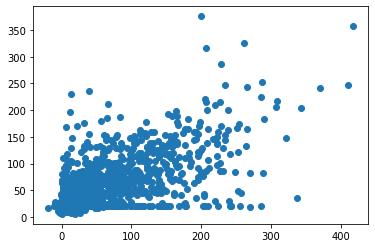

MSE: 2236.3
R^2: 0.45


,qb_dropback-1,qb_dropback-2,rush_attempt-1,qb_dropback-3,fanPts-1,incomplete_pass-1,pass_attempt-1,tackled_for_loss-1,rush_attempt-3,fumble-1,fumble-2,incomplete_pass-2,qb_hit-2,incomplete_pass-3,complete_pass-2,qb_hit-1,no_huddle-1,tackled_for_loss-2,complete_pass-3,tackled_for_loss-3,yards_gained-1,shotgun-3,fanPts-2,rush_yards-1,fumble-3,pass_touchdown-3,pass_attempt-3,interception-1,no_huddle-3,rush_attempt-2,touchdown-2,shotgun-1,rush_touchdown-3,rec_yards-2,yards_gained-3,touchdown-3,yards_gained-2,interception-2,pass_attempt-2,rush_yards-3,yards_after_catch-1,fanPts-3,complete_pass-1,shotgun-2,rush_touchdown-2,yards_after_catch-2,yards_after_catch-3,no_huddle-2,touchdown-1,rec_yards-3,air_yards-3,rec_yards-1,rush_touchdown-1,pass_touchdown-2,rush_yards-2,air_yards-2,pass_touchdown-1,air_yards-1,interception-3,qb_hit-3
1,-0.288,-0.270,-0.233,-0.196,0.194,0.187,0.152,0.135,-0.130,-0.114,-0.109,-0.098,-0.092,0.085,0.081,-0.079,-0.068,0.063,-0.060,0.058,0.058,-0.057,0.056,0.052,-0.049,0.042,0.037,-0.032,0.030,-0.029,-0.027,0.026,-0.025,0.021,0.020,-0.019,0.019,0.018,-0.017,0.016,-0.015,-0.015,0.014,0.011,0.010,0.008,0.008,-0.007,-0.006,0.006,-0.006,0.005,0.005,-0.005,-0.005,0.004,0.004,0.003,0.003,0.002


In [898]:
grid = GridSearchCV(
    linear_model.Ridge(),
    {'alpha':[10**x for x in range(-4,10)],'normalize':[True,False]},
    n_jobs = -1,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

clf = linear_model.Ridge(**grid.best_params_)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

print(f'MSE: {mean_squared_error(y_dev, y_pred).round(1)}')
print(f'R^2: {r2_score(y_dev, y_pred).round(2)}')

coefs = pd.DataFrame([X_train.columns,clf.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

Best parameters set found on development set:
{'alpha': 0.0001, 'normalize': True}


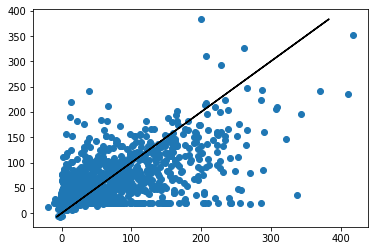

MSE: 2250.2
R^2: 0.45


,touchdown-2,touchdown-1,touchdown-3,fanPts-1,fanPts-2,fanPts-3,incomplete_pass-2,complete_pass-1,complete_pass-3,incomplete_pass-1,rush_attempt-3,incomplete_pass-3,complete_pass-2,rush_attempt-2,yards_gained-2,rush_attempt-1,yards_gained-3,yards_gained-1
1,-5.649,-5.069,-3.180,1.028,0.967,0.483,-0.448,-0.325,-0.308,0.155,-0.084,-0.076,0.067,-0.066,-0.063,-0.056,-0.020,-0.007


In [965]:
grid = GridSearchCV(
    linear_model.Ridge(),
    {'alpha':[10**x for x in range(-4,10)],'normalize':[True,False]},
    n_jobs = -1,
    cv = 5
)

grid.fit(X_train_select,y_train_select)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

clf = linear_model.Ridge(**grid.best_params_)
clf.fit(X_train_select,y_train_select)
y_pred = clf.predict(X_dev_select)

plt.scatter(y_dev_select, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

print(f'MSE: {mean_squared_error(y_dev, y_pred).round(1)}')
print(f'R^2: {r2_score(y_dev, y_pred).round(2)}')

coefs = pd.DataFrame([X_train_select.columns,clf.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

### Lasso Regression

#### Base model

C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11054.129647307098, tolerance: 3037.915068168809
  positive)


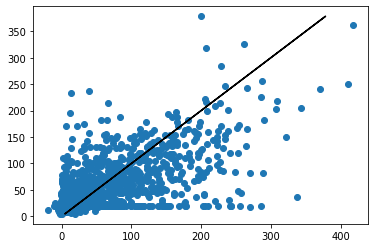

MSE: 2236.6
R^2: 0.45


,qb_dropback-1,incomplete_pass-1,fumble-2,tackled_for_loss-1,rush_attempt-1,pass_attempt-1,qb_dropback-2,qb_dropback-3,fanPts-1,incomplete_pass-2,qb_hit-2,rush_attempt-3,incomplete_pass-3,qb_hit-1,complete_pass-2,yards_gained-1,no_huddle-1,fumble-1,shotgun-3,rush_yards-1,fanPts-2,shotgun-1,yards_gained-2,yards_gained-3,rec_yards-2,rec_yards-1,yards_after_catch-1,rush_yards-2,complete_pass-1,rush_yards-3,rush_attempt-2,shotgun-2,yards_after_catch-2,air_yards-3,air_yards-2,yards_after_catch-3,air_yards-1,touchdown-3,rush_touchdown-1,tackled_for_loss-3,touchdown-1,pass_touchdown-1,interception-1,qb_hit-3,rush_touchdown-3,pass_touchdown-3,no_huddle-2,pass_attempt-2,pass_touchdown-2,rec_yards-3,rush_touchdown-2,tackled_for_loss-2,touchdown-2,fanPts-3,complete_pass-3,fumble-3,interception-3,no_huddle-3,pass_attempt-3,interception-2
1,-0.461,0.328,-0.314,0.300,-0.289,0.260,-0.257,-0.209,0.208,-0.166,-0.144,-0.128,0.120,-0.097,0.079,0.078,-0.070,-0.044,-0.040,0.039,0.036,0.034,0.027,0.024,0.015,-0.015,-0.013,-0.012,0.012,0.010,-0.009,0.007,0.006,-0.005,0.005,0.005,0.002,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000


In [963]:
regr = linear_model.Lasso()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

print(f'MSE: {mean_squared_error(y_dev, y_pred).round(1)}')
print(f'R^2: {r2_score(y_dev, y_pred).round(2)}')

coefs = pd.DataFrame([X_train.columns,regr.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Best parameters set found on development set:
{'alpha': 0.01, 'normalize': True}


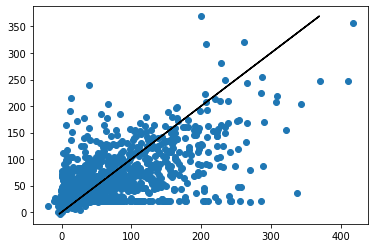

MSE: 2224.2
R^2: 0.45


,pass_touchdown-3,touchdown-3,rush_touchdown-2,fumble-2,fumble-1,touchdown-2,rush_touchdown-3,pass_touchdown-2,qb_hit-2,rush_touchdown-1,interception-1,qb_hit-1,interception-2,pass_touchdown-1,fumble-3,incomplete_pass-1,tackled_for_loss-1,incomplete_pass-2,interception-3,qb_hit-3,fanPts-1,qb_dropback-1,tackled_for_loss-2,tackled_for_loss-3,touchdown-1,qb_dropback-3,qb_dropback-2,rush_attempt-1,incomplete_pass-3,no_huddle-1,complete_pass-3,rush_attempt-3,complete_pass-2,shotgun-3,rush_yards-1,fanPts-2,pass_attempt-1,no_huddle-3,shotgun-1,yards_gained-1,complete_pass-1,rush_attempt-2,rec_yards-1,pass_attempt-2,rec_yards-2,fanPts-3,rush_yards-3,shotgun-2,pass_attempt-3,no_huddle-2,yards_gained-2,yards_after_catch-2,yards_gained-3,yards_after_catch-1,rec_yards-3,yards_after_catch-3,air_yards-2,air_yards-3,air_yards-1,rush_yards-2
1,2.318,-1.959,1.490,-1.469,-1.361,-1.320,1.289,1.272,-0.663,0.568,-0.505,-0.473,0.427,0.425,-0.376,0.309,0.285,-0.268,0.220,0.180,0.170,-0.162,0.160,0.158,-0.150,-0.133,-0.129,-0.127,0.127,-0.104,-0.102,-0.095,0.071,-0.059,0.052,0.042,0.042,0.036,0.035,0.033,0.030,-0.029,0.026,-0.023,0.021,0.020,0.016,0.015,-0.014,-0.014,0.012,0.011,0.010,-0.010,0.009,0.008,0.007,-0.006,0.004,0.003


In [962]:
grid = GridSearchCV(
    linear_model.Lasso(),
    {'alpha':[10**x for x in range(-4,10)],'normalize':[True,False]},
    n_jobs = -1,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

clf = linear_model.Ridge(**grid.best_params_)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

print(f'MSE: {mean_squared_error(y_dev, y_pred).round(1)}')
print(f'R^2: {r2_score(y_dev, y_pred).round(2)}')

coefs = pd.DataFrame([X_train.columns,clf.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

Best parameters set found on development set:
{'alpha': 0.0001, 'normalize': True}


C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2912380.884782414, tolerance: 3037.915068168809
  positive)


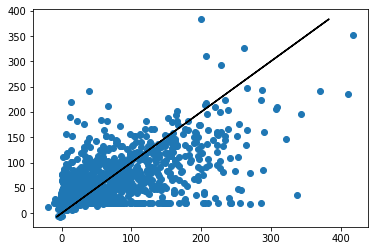

MSE: 2250.2
R^2: 0.45


,touchdown-2,touchdown-1,touchdown-3,fanPts-1,fanPts-2,fanPts-3,incomplete_pass-2,complete_pass-1,complete_pass-3,incomplete_pass-1,rush_attempt-3,incomplete_pass-3,complete_pass-2,rush_attempt-2,yards_gained-2,rush_attempt-1,yards_gained-3,yards_gained-1
1,-5.649,-5.069,-3.180,1.028,0.967,0.483,-0.448,-0.325,-0.308,0.155,-0.084,-0.076,0.067,-0.066,-0.063,-0.056,-0.020,-0.007


In [961]:
grid = GridSearchCV(
    linear_model.Lasso(),
    {'alpha':[10**x for x in range(-4,10)],'normalize':[True,False]},
    n_jobs = -1,
    cv = 5
)

grid.fit(X_train_select,y_train_select)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

clf = linear_model.Ridge(**grid.best_params_)
clf.fit(X_train_select,y_train_select)
y_pred = clf.predict(X_dev_select)

plt.scatter(y_dev_select, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

print(f'MSE: {mean_squared_error(y_dev, y_pred).round(1)}')
print(f'R^2: {r2_score(y_dev, y_pred).round(2)}')

coefs = pd.DataFrame([X_train_select.columns,clf.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs